## NYC Taxi Trips Project
### Austin Stegall
### IA 626
#### 2/28/2020

---

### Overview

This project will use a dataset that contains information about taxi rides in NYC.  This dataset will be used to answer the following questions and serve as an exercise to get familiar with processing larger datasets.
Questions:
- What time range does your data cover?  How many rows are there total?
- What are the field names?  Give descriptions for each field.
- Give some sample data for each field.
- What MySQL data types would you need to store each of the fields?
    - int(xx), varchar(xx),date,datetime,bool, decimal(m,d)
- What is the geographic range of your data (min/max - X/Y)?
    - Plot this (approximately on a map)
- What are the distinct values for each field? (If applicable)
- For other numeric types besides lat and lon, what are the min and max values?
- Create a chart which shows the average number of passengers each hour of the day.
- Create a new CSV file which has only one out of every thousand rows.
- Repeat step 8 with the reduced dataset and compare the two charts.



---

### The Data:
The data set resides in a .csv file of ~2.2Gb.  This is too big for microsoft excel to open and render a notebook for so the data will have to be viewed by other means.

In [4]:
import csv
import time
import pprint as p
from datetime import datetime, time
import pandas as pd
from plotnine import *

In [2]:
# Read in data and time:
import csv,time

start = time.time()

# Read in .csv file
with open("trip_data_2.csv") as f:
    data = [{k: str(v) for k, v in row.items()}
        for row in csv.DictReader(f, skipinitialspace=True)]
print("Loading time : " + str(time.time()-start))

Loading time : 257.1388840675354


Looks like the data took 257 seconds or about 4.3 minutes to load into memory.  Now we can start examining it.  Note that we will use another method of reading the file line by line in future questions to demonstrate its speed.

In [11]:
# Display first column and column names
n=0
for line in data:
    p.pprint(line)
    n+=1
    if n==1:
        break

{'dropoff_datetime': '2013-02-08 23:42:58',
 'dropoff_latitude': '40.718903',
 'dropoff_longitude': '-73.984421',
 'hack_license': 'D961332334524990D1BBD462E2EFB8A4',
 'medallion': '1B5C0970F2AE8CFFBA8AE4584BEAED29',
 'passenger_count': '1',
 'pickup_datetime': '2013-02-08 23:35:14',
 'pickup_latitude': '40.724487',
 'pickup_longitude': '-73.992439',
 'rate_code': '1',
 'store_and_fwd_flag': 'N',
 'trip_distance': '.80',
 'trip_time_in_secs': '463',
 'vendor_id': 'CMT'}


It looks like there are 14 variables with different formats and datatypes.  This information appears to be taxi driver pick up, drop off, and other type of information per taxi ride.

### Question 1:
What time range does your data cover? How many rows are there total?

In order to find the date range, the minimum and maximum date must be found.  To accomplish this, we will need to read each line of the file to find the min/max date.  The first date in the file will be initialized as the min and max date.  Initializing the date as the first date in the file and not some random date ensures that our random initialization doesn’t fall out of the date range in the actual file.  Each date will be compared to this initial value and set equal to that value if older or newer depending on if the min or max date is being determined in that particular loop.  It should be noted that the datetime from the file had to be converted to a datetime type that python recognizes.  

A row counter will return the final number of rows in the file.  This row counter will piggy back off of the main loop reading the files.

In [6]:
# determine time range and number of rows in data:

i=0 # initialize row counter
# initialize min and max date with first value of datetime stripped from dictionary and 
# convert into a datetime 
n=0
for line in data:
    min_datetime = datetime.strptime(line['pickup_datetime'], '%Y-%m-%d %H:%M:%S')
    max_datetime = min_datetime
    n+=1
    if n==1:
        break

# loop through and find min max date values while counting rows
for line in data:
    i+=1
    datetime = datetime.strptime(line['pickup_datetime'], '%Y-%m-%d %H:%M:%S')
    
    if datetime >= min_datetime:
        min_datetime = min_datetime
    else:
        min_datetime = datetime
        
    if datetime >= max_datetime:
        max_datetime = datetime
    else:
        max_datetime = max_datetime

print("There are {:d} number of rows in this dataset\n".format(i))
print("The date range of the data is from:",min_datetime,"to",max_datetime)

#### Date range: 
- Min: 2013-02-01 00:00:00
- Max: 2013-02-28 23:59:59

Number of rows = 13,990,176

It looks like there this data is for the month of February in 2013.  There are about 14 million rows in this data set.

---
### Question 2 and 3:
What are the field names?  Give descriptions for each field. Give some sample data for each field.

To show the field names and some sample data, the first row of data will be read into a pandas dataframe and displayed.

In [122]:
# print field names:
n=0
for line in data:
    #p.pprint(line)
    pd_line = pd.DataFrame(line.items())
    pd_line.columns = ['Variable Name', 'Value']
    display(pd_line.style.hide_index()) # hide row index column
    n+=1
    if n==1:
        break

Variable Name,Value
medallion,1B5C0970F2AE8CFFBA8AE4584BEAED29
hack_license,D961332334524990D1BBD462E2EFB8A4
vendor_id,CMT
rate_code,1
store_and_fwd_flag,N
pickup_datetime,2013-02-08 23:35:14
dropoff_datetime,2013-02-08 23:42:58
passenger_count,1
trip_time_in_secs,463
trip_distance,.80


#### Column Names:
- *dropoff_datetime:* date and time drop off occurred
- *dropoff_latitude:* drop off location
- *dropoff_longitude:* drop off location
- *hack_license:* NYC Taxi Driver License 
- *medallion:* CPNC or a transferable permit allowing a taxicab driver to operate
- *passenger_count:* number of passengers
- all pick ups are the same as drop offs but pick up locations
- *rate_code:* classifier for how fare is charged?
- *store_and_fwd_flag:* This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server
- *trip_distance:* trip distance
- *trip_time_in_sec:* trip time
- *vendor_id:* a code indicating the provider associated with the trip record
---

### Question 4:
 What MySQL data types would you need to store each of the fields?
- *dropoff_datetime:*   DATETIME
- *dropoff_latitude:*   DECIMAL
- *dropoff_longitude:*  DECIMAL
- *hack_license:*       VARCHAR 
- *medallion:*          VARCHAR
- all pick ups are the same as drop offs
- *rate_code:*          CHAR
- *store_and_fwd_flag:* BOOLEAN
- *trip_distance:*      DECIMAL
- *trip_time_in_sec:*   INT
- *vendor_id:*          VARCHAR
---

### Question 5:
What is the geographic range of your data (min/max - X/Y)?
- Plot this (approximately on a map)

In order to find the min and max latitude and corresponding longitude we need to read each line.  By reading the file line by line, we won’t run into ram limitations.  The line will be read in as a list of stings.  The latitude and longitude can be found by using the 11th and 12th index of the list.  We will loop though and use the same logic when finding the min and max date.  These coordinates will then be plotted on a map for visualization purposes.

In [23]:
# find min and max long and lat using line by line read instead of conventional method
n=0
# find min and max long and lat using line by line read instead of conventional method
with open("trip_data_2.csv") as file:
    reader = csv.reader(file)
    for i, line in enumerate(reader):
        if i ==1: 
            min_lat_p = line[11]
            min_long_p = line[12]
            min_lat_q = line[11]
            min_long_q = line[12]
        
            max_lat_p = min_lat_p
            max_long_p = min_long_p
            max_lat_q = min_lat_q
            max_long_q = min_long_q
            
        if i > 1:
            # Find min lat and corresponding long
            if min_lat_p >= line[11]:
                min_lat_p = line[11]
                min_long = line[12]
            else:
                min_lat_p = min_lat_p
                min_long = line[12]
            # find max lat and corresponding long
            if max_lat_p <= line[11]:
                max_lat_p = line[11]
                max_long = line[12]
            else:
                max_lat_p = min_lat_p
                max_long = line[12]            

    #print("Min lat long pair based on lat is:\n")
    print("Min lat: ",min_lat_p,"\n","Min long: ",min_long)
    #print("Max lat long pair based on lat is:\n")
    print("Max lat: ",max_lat_p,"\n","Max long: ",max_long)


Min lat:  -0.000042 
 Min long:  -73.968491
Max lat:  40.773724 
 Max long:  -73.968491


In [8]:
import folium
from folium.plugins import MarkerCluster
import pandas as pd

In [22]:
# Create map of coordinates
#Define coordinates of where we want to center our map
taxi_coords = [41.2000, -74.0060]

#Create the map
my_map = folium.Map(location = taxi_coords, zoom_start = 8)

# add min max coordinate markers to map
min_coords = [42.0000, -73.968491]
max_coords = [40.773724, -73.968491]

print(min2,"\n",max2)
folium.Marker(min_coords, popup = 'Max Lat').add_to(my_map)
folium.Marker(max_coords, popup = 'Min Lat').add_to(my_map)

#Display the map
my_map

['40.773724', '9.6999996E-5'] 
 ['40.773724', '-73.968491']


---
### Question 6:
What are the distinct values for each field? (If applicable)?

To count the number of distinct values we can initialize a defaultdict that will serve as empty dictionary to append to.  The file will be read line by line and the number of unique instances will be counted.  This counter works by returning a true or false when the word being counted is found in the specific index of the list.  This is because the line of data being read is always read in as a list of strings.  There is probably a more efficient way to do this task than this method.

In [50]:
from collections import defaultdict
d = defaultdict(int)
with open("trip_data_2.csv") as file:
    reader = csv.reader(file)
    for i, line in enumerate(reader):
        if i != 0:
            for word in line:
                if word in line[7]:
                    d[word]+=1
#    p.pprint(d)
        

Each variable will have a certain number of distinct values.  After examining the data set’s variables, it would be impractical or a useless metric to count the distinct value of all variables.  Knowing the distinct number of trip time in seconds is not very useful.  The following variables have an applicable distinct value.  This was done by varying the index in the list of strings --> ex: line[7] = number of passengers.

- Vendor ID: CMT and VTS
- Rate Code: 0, 1, 2, 3, 4, 5, 6, 7
- Store and fwd flag: Y and N
- Passenger Count: 1, 2, 3, 4, 5, 6, 7, 8, 9


---

### Question 7:
For other numeric types besides lat and lon, what are the min and max values?

There exists a min and max value for other variables not examined such as trip distance and trip time.  We will use the same logic as before when determining min and max values.

In [88]:
# calculate min and max for trip distance and trip time

# set min and max values to first value in data set:
n=0
for temp2 in data:
    min_time = line['trip_time_in_secs']
    max_time = min_time
    min_trip_dist = line['trip_distance']
    max_trip_dist = min_trip_dist
    n+=1
    if n==1:
        break

# loop through and find min max values
i=0
for line in data:
    time = line['trip_time_in_secs']
    trip = line['trip_distance']
    if time >= min_time:
        min_time = min_time
    else:
        min_time = time
        
    if time >= max_time:
        max_time = time
    else:
        max_time = max_time
    
    if trip >= min_trip_dist:
        min_trip_dist = min_trip_dist
    else:
        min_trip_dist = trip
        
    if trip >= max_trip_dist:
        max_trip_dist = trip
    else:
        max_trip_dist = max_trip_dist
    
#     i+=1
#     if i==10:
#         break
print("Minimum Time:",min_time,"s")
print("Maximum Time:",max_time,"s")
print("Minimum Trip Distance:",min_trip_dist,"mi")
print("Maximum Trip Distance:",max_trip_dist,"mi")

Minimum Time: 0 s
Maximum Time: 999 s
Minimum Trip Distance: .00 mi
Maximum Trip Distance: 99.70 mi


There will be min and max values for the following:

- *trip_distance:*     
- *trip_time_in_sec:* 

---
### Question 8:
Create a chart which shows the average number of passengers each hour of the day.

To find the average number of passengers per hour there are several things that need to be done.  First, we will loop through line by line, skipping the first line as it is just the headers, and convert the pickup datetime to a datetime type and extract the hour from that value.  The value for passenger count will also be extracted and stored.  Now a dictionary will be created with the keys equal to the hour of the taxi pick up and value equal to the number of occurrences of that hour (histogram of pickup time binned by hour).  Another loop will be used to create a dictionary were the key is equal to the time of day and the value is equal to the total number of passengers that were picked up in that hour.  The two dictionaries will be transformed into pandas dataframes.  A column will be created that is the total number of passengers in the hour divided by the total number of rides in the hour.   This will be plotted to visualize how the distribution changes per hour. 

In [56]:
# loop through and find min max date values while counting rows
i=0
temp = 0
passenger_hist = {}
sum_hist={}

with open("trip_data_2.csv") as file:
    reader = csv.reader(file)
    for i, line in enumerate(reader):
        if i != 0:
            datetime = datetime.strptime(line[5], '%Y-%m-%d %H:%M:%S')
            time = datetime.hour    
            p_count = line[7]

            # Create dictionary to get number of rides per hour
            if time in passenger_hist.keys():
                passenger_hist[time] +=1        
            else:
                passenger_hist[time] = 1 
            # create dict. to get number of passengers per hour
            if time in sum_hist.keys():
                temp = temp + int(p_count)
                sum_hist[time] = temp
            else:
                sum_hist[time] = temp

In [57]:
# create dataframe of passengers per hour
pass_per_hour = pd.DataFrame(sum_hist.items())
pass_per_hour.columns = ['time', 'total_pass_count']


pass_hist = pd.DataFrame(passenger_hist.items())
pass_hist.columns = ['time', 'total_rides_in_hour']

#print(pass_hist)

avg_per_hour = pass_per_hour
avg_per_hour.total_pass_count = avg_per_hour.total_pass_count/pass_hist.total_rides_in_hour

avg_per_hour.columns = ['time', 'avg_pass_count']

display(avg_per_hour)

,time,avg_pass_count
0,23,35.247876
1,12,34.392277
2,8,36.754603
3,9,36.074553
4,19,26.669510
5,22,30.649194
6,2,83.669317
7,0,45.025298
8,14,33.098326
9,18,27.102969


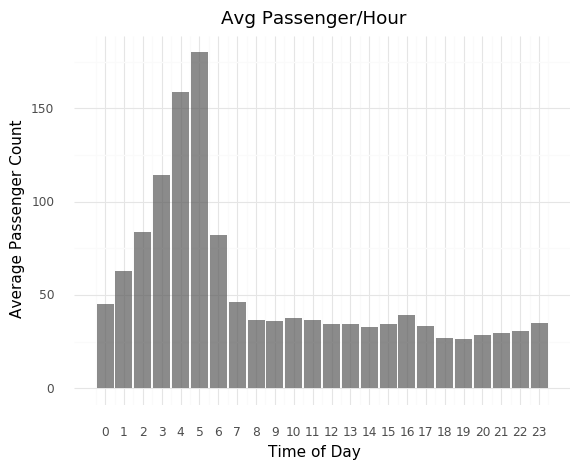

<ggplot: (-9223371910359768720)>

In [58]:
# Create plot, this represents total sum of passengers divided by the number of rides binned by hour
# of the day.

plot1 = (ggplot(avg_per_hour, aes(x = 'time', y = 'avg_pass_count'))+ 
               geom_bar(stat = "identity", alpha = 0.7)+
               scale_x_continuous(breaks = range(0,24,1))+
               labs(x = "Time of Day", y = "Average Passenger Count", title = "Avg Passenger/Hour" )+
               theme_minimal())
    
plot1

By analyzing the plot above, there clearly exists a spike in taxi rides in the early morning hours where as rides level off during the day.

---
### Question 9:
Create a new CSV file which has only one out of every thousand rows.

In [ ]:
n=0
with open("trip_data_2.csv") as file:
    reader = csv.reader(file)
    
    # create new file to append to
    f2 = open('trip_data_2_sample.csv','w')
    f2.write("")
    f2.close()
    
    # open file in append mode
    f2 = open('trip_data_2_sample.csv','a')
    # set writer
    writer = csv.writer(f2, delimiter=',',lineterminator='\n')
    # loop through and write every 1000 lines
    for i, line in enumerate(reader):
        if i == 0 or i == 1:
            writer.writerow(line)
        if n == 1000:
            writer.writerow(line)
            n=0
        n+=1
f2.close()

Creating a new file which has only one out of every thousand rows is easy.  Just simply read the file in line by line keeping a counter that writes a line everytime it counts to 1000.  This counter is then set back to 0 and the process starts over again.  This produces a new file that is one row for every thousand rows of the original file.

---
## Question 10:
Repeat step 8 with the reduced dataset and compare the two charts.

The same code can be used from question 8 with new variables.  To aid in comparing the plots, the results from the data subset will be plotted as red bars to highlight the difference in values.

In [52]:
temp = 0
passenger_hist2 = {}
sum_hist2={}

with open("trip_data_2_sample.csv") as file:
    reader = csv.reader(file)
    for i, line in enumerate(reader):
        if i != 0:
            datetime = datetime.strptime(line[5], '%Y-%m-%d %H:%M:%S')
            time = datetime.hour 
            p_count = line[7]
            
            # Create dictionary to get number of rides per hour
            if time in passenger_hist2.keys():
                passenger_hist2[time] +=1        
            else:
                passenger_hist2[time] = 1 
            # Create dict. to get number of passengers per hour
            if time in sum_hist2.keys():
                temp = temp + int(p_count)
                sum_hist2[time] = temp
            else:
                sum_hist2[time] = temp
#         if i == 3:
#             break

In [53]:
# create dataframe of passengers per hour
pass_per_hour2 = pd.DataFrame(sum_hist2.items())
pass_per_hour2.columns = ['time', 'total_pass_count2']


pass_hist2 = pd.DataFrame(passenger_hist2.items())
pass_hist2.columns = ['time', 'total_rides_in_hour2']

#print(pass_hist)

avg_per_hour2 = pass_per_hour2
avg_per_hour2.total_pass_count2 = avg_per_hour2.total_pass_count2/pass_hist2.total_rides_in_hour2

avg_per_hour2.columns = ['time', 'avg_pass_count2']

# add third column
#avg_per_hour2['avg_pass_count1'] = avg_per_hour.avg_pass_count


display(avg_per_hour2)

,time,avg_pass_count2
0,23,36.243827
1,15,32.527273
2,13,34.281752
3,16,39.982818
4,14,33.071831
5,17,31.790698
6,12,36.328682
7,18,30.430809
8,19,25.538798
9,20,27.700592


In [54]:
# Create plot, this represents total sum of passengers divided by the number of rides binned by hour
# of the day.

plot2 = (ggplot(avg_per_hour2, aes(x = 'time', y = 'avg_pass_count2'))+ 
               geom_bar(stat = "identity", alpha = 0.7)+
               scale_x_continuous(breaks = range(0,24,1))+
               labs(x = "Time of Day", y = "Average Passenger Count", title = "Avg Passenger/Hour" )+
               theme_minimal())

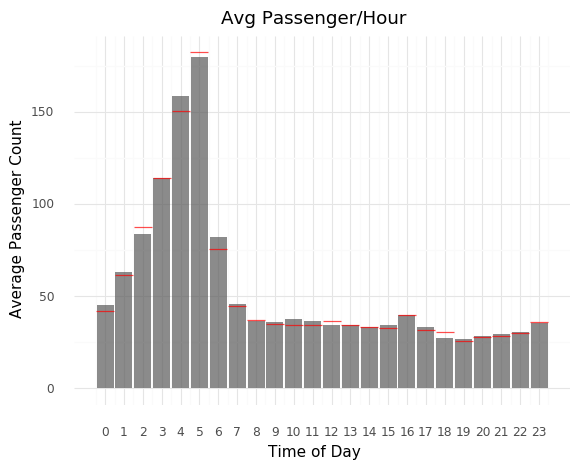

<ggplot: (-9223371910361890860)>

In [79]:
# Plot both on same plot

plot3 = plot1 + (geom_point(avg_per_hour2, aes(x = 'time', y = 'avg_pass_count2'), 
                          stat = "identity", alpha = 0.7, fill = 'red',shape = '_', size=6.8))

plot3

The plot above shows avg passengers per hour of the day.  The gray bars indicates the passenger count from the original data set while the red bars indicate the count from the sample set.  We can see that the smaller sample matches the distribution of the larger sample quite well. 